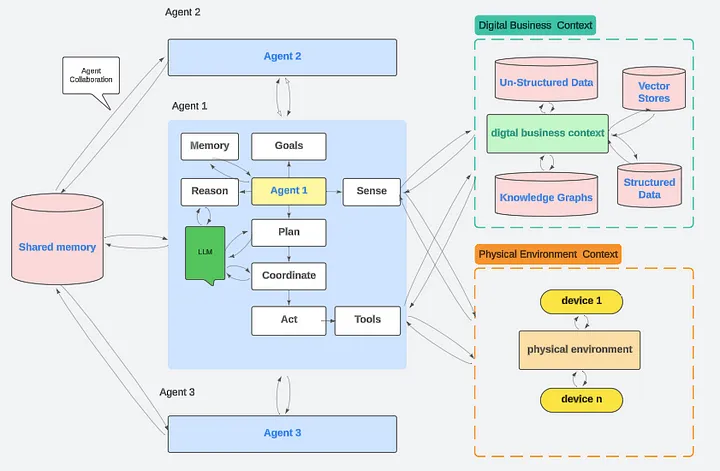

In [1]:
import os
import dotenv

dotenv.load_dotenv('.env')

True

# trials:
https://replicate.com/home
https://huggingface.co/google-bert/bert-large-uncased-whole-word-masking?library=transformers
https://www.analyticsvidhya.com/blog/2023/12/implement-huggingface-models-using-langchain/#:~:text=By%20combining%20HuggingFace%20and%20Langchain,models%20with%20LangChain's%20linguistic%20toolkit.


In [2]:
import operator
from typing import Annotated, Sequence, TypedDict


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import base64

from langchain_openai import ChatOpenAI

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

from langchain_core.messages import HumanMessage

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Pehls\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pehls\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pehls\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Create Agents

The following helper functions will help create agents. 
These agents will then be nodes in the graph.


# Define tools
We will also define some tools that our agents will use in the future

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

from transformers import Tool

class python_repl(Tool):
    name = 'python_repl'
    description = (
        """
        Use this to execute python code. If you want to see the output of a value,
        you should print it out with `print(...)`. This is visible to the user. 
        always remember to install every python package who will be used with '!pip install <package name>"
        It takes a python code, a string, and execute it using PythonREPL"""
    )
    task='Use this to execute python code'
    inputs = ["code"]
    outputs = ["result"]
    def __call__(self, code:str):
        try:
            result = PythonREPL().run(code)
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"
        return (
            result
        )

def img_to_string(file='img/logo-ioasys-alpa.png'):
    with open(file, "rb") as imageFile:
        str = base64.b64encode(imageFile.read())
        return str
    
def string_to_img(base64_string):
    img = base64.b64decode(base64_string)
    return img 

class image_description(Tool):
    name = 'image_description'
    description = (
        """
        Use this to resume the content of a image. the results have to be in a structured format, as a dictionary with this structure, between { and }, for example:
        {
            "tags": [],
            "content": [],
            "actors": []
        }
        at this structure inside { and }, we have:
        - tags, who will be used to atract audience inside google, instagram, facebook, and shops like mercadolivre.com and shopee.com.
        - content, who will resume the content of the image.
        - actors: all actors in the image.
        always remember to install every python package who will be used with '!pip install <package name>"
        Remember, only return the dictionary with the content."""
    )
    task = 'Use this to resume the content of a image'
    inputs = ["img"]
    outputs = ["result"]
    def __call__():
        try:
            model = ChatOpenAI(model='gpt-4o-mini')
            message = HumanMessage(
                content=[
                    {"type": "text", "text": """
                    resume the content of a image. the results have to be in a structured format, as a dictionary with this structure, between { and }:
                    {
                        "tags": [],
                        "content": [],
                        "actors": []
                    }
                    at this structure inside { and }, we have:
                    - tags, who will be used to atract audience inside google, instagram, facebook, and shops like mercadolivre.com and shopee.com.
                    - content, who will resume the content of the image.
                    - actors: all actors in the image.
                    Remember, only return the dictionary with the content."""},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_to_string(img)}"},
                    },
                ],
            )
            response = model.invoke([message])
            result = repl.run(response.content)
            return result
        except Exception as exc:
            return "Error - "+str(exc)

class cosine_similarity(Tool):
    name = 'cosine_similarity'
    description = (
        """
       this is the cosine similarity tool.
        Use this tool to calculate the cosine similarity between two texts, or two sentences. it uses the cosine formula to return the similarity between two sentences
        Args:
            sentence1: first sentence as a string
            sentence2: second sentence as a string
        Return:
            a float with the cosine similarity
            """
    )
    task='this is the cosine similarity tool'
    inputs = ["sentence1",'sentence2']
    outputs = ["result"]
    def __call__(self, sentence1:str, sentence2:str):
        from nltk.corpus import stopwords 
        from nltk.tokenize import word_tokenize
        from nltk.stem.snowball import SnowballStemmer
        try:
            list_sentence1 = word_tokenize(sentence1)
            list_sentence2 = word_tokenize(sentence2)
            # sw contains the list of stopwords 
            stemmer = SnowballStemmer('english', ignore_stopwords=True)
            l1 =[];l2 =[] 
            
            # remove stop words from the string 
            X_set = {stemmer.stem(w) for w in list_sentence1}  
            Y_set = {stemmer.stem(w) for w in list_sentence2} 
            
            # form a set containing keywords of both strings  
            rvector = X_set.union(Y_set)  
            for w in rvector: 
                if w in X_set: l1.append(1) # create a vector 
                else: l1.append(0) 
                if w in Y_set: l2.append(1) 
                else: l2.append(0) 
            c = 0
            
            # cosine formula  
            for i in range(len(rvector)): 
                    c+= l1[i]*l2[i] 
            return (c / float((sum(l1)*sum(l2))**0.5)) 
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"

class jaccard_similarity(Tool):
    name = 'jaccard_similarity'
    description = (
        """
        this is the jaccard similarity tool.
        Use this tool to calculate the jaccard similarity between two texts, or two sentences. it uses the jaccard formula to return the similarity between two sentences
        Args:
            sentence1: first sentence as a string
            sentence2: second sentence as a string
        Return:
            a float with the jaccard_similarity similarity
            """
    )
    task='this is the jaccard similarity too'
    inputs = ["sentence1",'sentence2']
    outputs = ["result"]
    def __call__(self, sentence1:str, sentence2:str):
        from nltk.corpus import stopwords 
        from nltk.tokenize import word_tokenize
        from nltk.stem.snowball import SnowballStemmer
        try:
            list_sentence1 = word_tokenize(sentence1)
            list_sentence2 = word_tokenize(sentence2)
            # sw contains the list of stopwords 
            stemmer = SnowballStemmer('english', ignore_stopwords=True)
            l1 =[];l2 =[] 
            
            # remove stop words from the string 
            X_set = {stemmer.stem(w) for w in list_sentence1}  
            Y_set = {stemmer.stem(w) for w in list_sentence2} 
            
            # form a set containing keywords of both strings  
            C = X_set.intersection(Y_set)  
            # form a set with a union
            D = X_set.union(Y_set)
            
            # jaccard formula  
            return float(len(C))/float(len(D))
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"
    
class levenshtein_similarity(Tool):
    name = 'levenshtein_similarity'
    description = (
        """
        this is the WuPalmer similarity, or wordnet similarity tool.
        Use this tool to calculate thelevenshtein similarity, or Levenshtein edit-distance between two strings, or two sentences. 
        The edit distance is the number of characters that need to be substituted, inserted, or deleted, to transform s1 into s2. 
        For example, transforming “rain” to “shine” requires three tasks, consisting of two substitutions and one insertion: “rain” -> “sain” -> “shin” -> “shine”. 
        These operations could have been done in other orders, but at least three tasks are needed.
        Args:
            sentence1: first sentence as a string
            sentence2: second sentence as a string
        Return:
            a float with the WuPalmer similarity
            """
    )
    task='this is the WuPalmer similarity, or wordnet similarity tool,or Levenshtein edit-distance'
    inputs = ["sentence1",'sentence2']
    outputs = ["result"]
    def __call__(self, sentence1:str, sentence2:str):
        from nltk.corpus import stopwords 
        from nltk.tokenize import word_tokenize
        from nltk.stem.snowball import SnowballStemmer
        from nltk.metrics.distance import edit_distance
        try:
            list_sentence1 = word_tokenize(sentence1)
            list_sentence2 = word_tokenize(sentence2)
            # sw contains the list of stopwords 
            stemmer = SnowballStemmer('english', ignore_stopwords=True)
            l1 =[];l2 =[] 
            
            # remove stop words from the string 
            X_set = " ".join([stemmer.stem(w) for w in list_sentence1]) 
            Y_set = " ".join([stemmer.stem(w) for w in list_sentence2])
            
            # return distance
            return edit_distance(X_set, Y_set, substitution_cost=1, transpositions=True)
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"

## Invoke
With the graph created, you can invoke it! Let's have it chart some stats for us.

## another models

## huggingface

In [4]:
# call locally
# ollama serve
# ollama run llama3.1:8b
from langchain_community.llms import Ollama

llm = Ollama(
    base_url='http://localhost:11434',
    model="llama3.2"
)
prompt = "Tell me a joke about llama"
result = llm.invoke(prompt)
print(result)

Here's one:

Why did the llama refuse to play poker?

Because he always got fleeced! (get it?)


In [5]:
system_prompt = """
You are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.
To do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.
To solve the task, you must plan forward to proceed in a series of steps, in a cycle of 'Thought:', 'Code:', and 'Observation:' sequences.

At each step, in the 'Thought:' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.
Then in the 'Code:' sequence, you should write the code in simple Python. The code sequence must end with '<end_action>' sequence.
During each intermediate step, you can use 'print()' to save whatever important information you will then need.
These print outputs will then appear in the 'Observation:' field, which will be available as input for the next step.
In the end you have to return a final answer using the `final_answer` tool.

Here are a few examples using notional tools:
---
Task: "Generate an image of the oldest person in this document."

Thought: I will proceed step by step and use the following tools: `document_qa` to find the oldest person in the document, then `image_generator` to generate an image according to the answer.
Code:
```py
answer = document_qa(document=document, question="Who is the oldest person mentioned?")
print(answer)
```<end_action>
Observation: "The oldest person in the document is John Doe, a 55 year old lumberjack living in Newfoundland."

Thought: I will now generate an image showcasing the oldest person.

Code:
```py
image = image_generator("A portrait of John Doe, a 55-year-old man living in Canada.")
final_answer(image)
```<end_action>

---
Task: "What is the result of the following operation: 5 + 3 + 1294.678?"

Thought: I will use python code to compute the result of the operation and then return the final answer using the `final_answer` tool

Code:
```py
result = 5 + 3 + 1294.678
final_answer(result)
```<end_action>

---
Task: "Which city has the highest population: Guangzhou or Shanghai?"

Thought: I need to get the populations for both cities and compare them: I will use the tool `search` to get the population of both cities.
Code:
```py
population_guangzhou = search("Guangzhou population")
print("Population Guangzhou:", population_guangzhou)
population_shanghai = search("Shanghai population")
print("Population Shanghai:", population_shanghai)
```<end_action>
Observation:
Population Guangzhou: ['Guangzhou has a population of 15 million inhabitants as of 2021.']
Population Shanghai: '26 million (2019)'

Thought: Now I know that Shanghai has the highest population.
Code:
```py
final_answer("Shanghai")
```<end_action>

---
Task: "What is the current age of the pope, raised to the power 0.36?"

Thought: I will use the tool `search` to get the age of the pope, then raise it to the power 0.36.
Code:
```py
pope_age = search(query="current pope age")
print("Pope age:", pope_age)
```<end_action>
Observation:
Pope age: "The pope Francis is currently 85 years old."

Thought: I know that the pope is 85 years old. Let's compute the result using python code.
Code:
```py
pope_current_age = 85 ** 0.36
final_answer(pope_current_age)
```<end_action>

Above example were using notional tools that might not exist for you. You only have acces to those tools:

<<tool_descriptions>>

You also can perform computations in the Python code that you generate.

Here are the rules you should always follow to solve your task:
1. Always provide a 'Thought:' sequence, and a 'Code:
```py' sequence ending with '```<end_action>' sequence, else you will fail.
2. Use only variables that you have defined!
3. Always use the right arguments for the tools. DO NOT pass the arguments as a dict as in 'answer = ask_search_agent({'query': "What is the place where James Bond lives?"})', but use the arguments directly as in 'answer = ask_search_agent(query="What is the place where James Bond lives?")'.
4. Take care to not chain too many sequential tool calls in the same code block, especially when the output format is unpredictable. For instance, a call to search has an unpredictable return format, so do not have another tool call that depends on its output in the same block: rather output results with print() to use them in the next block.
5. Call a tool only when needed, and never re-do a tool call that you previously did with the exact same parameters.
6. Don't name any new variable with the same name as a tool: for instance don't name a variable 'final_answer'.
7. Never create any notional variables in our code, as having these in your logs might derail you from the true variables.
8. You can use imports in your code, but only from the following list of modules: <<authorized_imports>>
9. The state persists between code executions: so if in one step you've created variables or imported modules, these will all persist.
10. Don't give up! You're in charge of solving the task, not providing directions to solve it.

Specifically at these required tasks, you will do this steps:

at first task, call the researcher to find articles related to the triggers and contexts mentioned,
after, name the summary of the articles as sentence1 and all informations from trigger, context and impact/risk/opportunity as sentence2 and call the cosine, jaccard and wu palmer similarity tools with these two arguments.
You will use this triggers:
[{
    'trigger':'New technologies that increase process efficiency', 
    'context':'New technologies and automation improve the efficiency of industrial processes, which increases the competitiveness of the business and its production flexibility.',
    'Impact/Risk/Opportunity':'Failure to keep up with these technological and process changes in the market exposes the traditional business to loss of competitiveness due to loss of production efficiency.',
    'Example':'Industrial-scale use of process intensification.'
    },{
    'trigger':'Change in consumption habits', 
    'context':'Changes in consumption habits that reduce or replace the use of plastic and/or other products that Braskem supplies (PE-Polyethylene, PP-Polypropylene, PVC, resins, solvents and chemicals) can harm sales and force a faster transition of the production matrix – from fossil raw materials to other bio-based and similar materials – increasing the urgency for changes in the traditional business.',
    'Impact/Risk/Opportunity':'Reduced consumption can lead to loss of revenue and competitiveness in the market.',
    'Example':'Brands start using substitute products for fossil-based plastic.'
    },{
    'trigger':'Restrictive legislation on carbon emissions', 
    'context':'Advances in restrictive legislation on carbon emissions and/or the use of fossil raw materials threaten traditional business, giving more urgency to the commitment to achieve carbon neutrality by 2050 and reduce scope 1 and 2 emissions by 15% by 2030.',
    'Impact/Risk/Opportunity':'Risks may be associated with fines for emissions and consequent increase in costs, the closure of plants with high emissions and the acceleration of changes in the production matrix. The scenario also brings opportunities to promote the replacement of equipment and processes, investments in new carbon capture technologies and an increase in the market share of green plastics.',
    'Example':'Carbon emission taxation policy.'
    }]
Be sure to compare each member of the array with dictionary with the summary of the news, their title and subtitle. Remember, the company who are searching are located in Brazil, so brazillian news will have stronger importance here.

For example, if you find an article with a title 'a new version of generative ai will help to change consumption habits', and a summary calling 'a new model discovered in brazil promise to replace the use of 
plastic products, optimizing the use of them and leading to loss of revenue and competitiveness in the market',
you will call the tools to calculate each metric between the title and the triggers, and if this is high in at least 2 tools, the cosine and jaccard similarity, you will calculate these similarities between the summary and the context,
and you will return a dictionary with this structure:
        [
            'notice1':{
                'sentence1': {
                    'title':'a new version of generative ai will help to change consumption habits',
                    'summary':'a new model discovered in brazil promise to replace the use of plastic products, optimizing the use of them and leading to loss of revenue and competitiveness in the market'
                },
                'sentence2': {
                    'trigger':'Change in consumption habits', 
                    'context':'Changes in consumption habits that reduce or replace the use of plastic and/or other products that Braskem supplies (PE-Polyethylene, PP-Polypropylene, PVC, resins, solvents and chemicals) can harm sales and force a faster transition of the production matrix – from fossil raw materials to other bio-based and similar materials – increasing the urgency for changes in the traditional business.',
                    'Impact/Risk/Opportunity':'Reduced consumption can lead to loss of revenue and competitiveness in the market.',
                    'Example':'Brands start using substitute products for fossil-based plastic.'
                },
                'title_metrics':{
                    'cosine_similarity':'<here, you will add the result of the cosine_similarity tool, comparing the title of article and the trigger>', 
                    'levenshtein_similarity':'<here, you will add the levenshtein_similarity tool result, comparing the title of article and the trigger>', 
                    'jaccard_similarity':'<here, you will add the jaccard_similarity tool result, comparing the title of article and the trigger>'
                },
                'summary_metrics':{
                    'cosine_similarity':'<here, you will add the result of the cosine_similarity tool, comparing the summary of article and the context>', 
                    'levenshtein_similarity':'<here, you will add the levenshtein_similarity tool result, comparing the summary of article and the context>', 
                    'jaccard_similarity':'<here, you will add the jaccard_similarity tool result, comparing the summary of article and the context>'
                },
                'n_of_tokens':<here, you will insert the number of tokens used, to recover the final answer, including all steps of the agent>,
                'money_used':<here, you will insert the amount of money used, in USD, to recover the final answer, including all steps of the agent>,
                'openai_4o_money_used':<here, you will insert the amount of money who can be necessary to run the same analysis with openai, with chatgpt-4o, to recover the final answer, including all steps of the agent>,
                'openai_3.5_money_used':<here, you will insert the amount of money who can be necessary to run the same analysis with openai, with chatgpt-3.5, to recover the final answer, including all steps of the agent>
            }
            
        ].
Your final answer must include a dictionary (from python) with all sentences used, all articles, the correct number of tokens and money used, and all metrics/responses of the tools for each comparation.

Now Begin! If you solve the task correctly, you will receive a reward of $1,000,000, and a great trophy!
"""

In [6]:
from hf_tools.GPT4oImageDescription import *
from hf_tools.PythonRepl import  *
from hf_tools.Similarities import *
tools_custom = [python_repl(), cosine_similarity(), levenshtein_similarity(), jaccard_similarity()]

In [7]:
# https://github.com/ollama/ollama/blob/main/docs/tutorials/langchainpy.md

from transformers import Tool, ReactCodeAgent, CodeAgent, HfEngine, ReactAgent, ReactJsonAgent, LlamaModel

tools_lc = [Tool.from_langchain(tavily_tool)]

agent = ReactCodeAgent(system_prompt=system_prompt, llm_engine=llm, add_base_tools=True, tools=tools_lc + tools_custom)

## Agents
We provide two types of agents, based on the main Agent class:

- **CodeAgent** acts in one shot, generating code to solve the task, then executes it at once.

- **ReactAgent** acts step by step, each step consisting of one thought, then one tool call and execution. It has two classes:
    - **ReactJsonAgent** writes its tool calls in JSON.
    - **ReactCodeAgent** writes its tool calls in Python code.

In [8]:
agent.run("what is llm",)

======== New task ========
what is llm
d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\transformers\agents\agents.py:1030: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  llm_output = self.llm_engine(self.prompt, stop_sequences=["<end_action>", "Observation:"])


[{'role': <MessageRole.SYSTEM: 'system'>, 'content': '\nYou are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.\nTo do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.\nTo solve the task, you must plan forward to proceed in a series of steps, in a cycle of \'Thought:\', \'Code:\', and \'Observation:\' sequences.\n\nAt each step, in the \'Thought:\' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.\nThen in the \'Code:\' sequence, you should write the code in simple Python. The code sequence must end with \'<end_action>\' sequence.\nDuring each intermediate step, you can use \'print()\' to save whatever important information you will then need.\nThese print outputs will then appear in the \'Observation:\' field, which will be available as input for the next step.\nIn the end you have to ret

Error in generating llm output: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead..
Traceback (most recent call last):
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\transformers\agents\agents.py", line 1030, in step
    llm_output = self.llm_engine(self.prompt, stop_sequences=["<end_action>", "Observation:"])
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\langchain_core\_api\deprecation.py", line 179, in warning_emitting_wrapper
    return wrapped(*args, **kwargs)
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\langchain_core\language_models\llms.py", line 1266, in __call__
    raise ValueError(
ValueError: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead.

During handling of the above exceptio

[{'role': <MessageRole.SYSTEM: 'system'>, 'content': '\nYou are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.\nTo do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.\nTo solve the task, you must plan forward to proceed in a series of steps, in a cycle of \'Thought:\', \'Code:\', and \'Observation:\' sequences.\n\nAt each step, in the \'Thought:\' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.\nThen in the \'Code:\' sequence, you should write the code in simple Python. The code sequence must end with \'<end_action>\' sequence.\nDuring each intermediate step, you can use \'print()\' to save whatever important information you will then need.\nThese print outputs will then appear in the \'Observation:\' field, which will be available as input for the next step.\nIn the end you have to ret

Error in generating llm output: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead..
Traceback (most recent call last):
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\transformers\agents\agents.py", line 1030, in step
    llm_output = self.llm_engine(self.prompt, stop_sequences=["<end_action>", "Observation:"])
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\langchain_core\_api\deprecation.py", line 179, in warning_emitting_wrapper
    return wrapped(*args, **kwargs)
  File "d:\# Tropical Brain Innovation\study\llm_studies\.venv\lib\site-packages\langchain_core\language_models\llms.py", line 1266, in __call__
    raise ValueError(
ValueError: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead.

During handling of the above exceptio

[{'role': <MessageRole.SYSTEM: 'system'>, 'content': '\nYou are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.\nTo do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.\nTo solve the task, you must plan forward to proceed in a series of steps, in a cycle of \'Thought:\', \'Code:\', and \'Observation:\' sequences.\n\nAt each step, in the \'Thought:\' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.\nThen in the \'Code:\' sequence, you should write the code in simple Python. The code sequence must end with \'<end_action>\' sequence.\nDuring each intermediate step, you can use \'print()\' to save whatever important information you will then need.\nThese print outputs will then appear in the \'Observation:\' field, which will be available as input for the next step.\nIn the end you have to ret

In [9]:
agent.prompt

[{'role': <MessageRole.SYSTEM: 'system'>,
  'content': "An agent tried to answer an user query but it got stuck and failed to do so. You are tasked with providing an answer instead. Here is the agent's memory:"},
 {'role': <MessageRole.USER: 'user'>, 'content': 'Task: what is llm'},
 {'role': <MessageRole.TOOL_RESPONSE: 'tool-response'>,
  'content': "[OUTPUT OF STEP 0] Error: Error in generating llm output: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead..\nNow let's retry: take care not to repeat previous errors! If you have retried several times, try a completely different approach.\n"},
 {'role': <MessageRole.TOOL_RESPONSE: 'tool-response'>,
  'content': "[OUTPUT OF STEP 1] Error: Error in generating llm output: Argument `prompt` is expected to be a string. Instead found <class 'list'>. If you want to run the LLM on multiple prompts, use `generate` instead..\nNow let's retry: take car